## Machine learning for time-series electric power load forecasting

**Author**: 
Petar Sarajcev, PhD
University of Split, FESB, Department of Power Engineering, Croatia, EU.

**Ausgrid Substation Data**
Ausgrid, “Distribution zone substation information data to share,” http://www.ausgrid.com.au/Common/About-us/Corporate-information/Data-to-share/DistZone-subs.aspx#.WYD6KenauUl, accessed May, 2019.

**DarkSky API** 
Weather data from https://darksky.net/dev

**Abstract**:
Substation level (132/11 kV) electric power load time-series data from the Ausgrid provider is studied, in combination with a local weather data gathered by means of using a DarkSky API. A machine learning ensemble is built (i.e. stacked ensemble) of several base models, in order to forecast substation hourly load for a weeks time, with the use of weather information (i.e. short-term load forecasting). Some of the base models are also ensembles themselves (Boosting ensembles, Forest of trees, etc.), which are stacked using the ElasticNet linear regression, and a weighted average, as a second-stage models. Training data set is used for training the base models, where optimal base model's hyper-parameters are determined by the grid search with time-series cross-validation on the training set. Bayesian optimization is used for fine-tunning the model's hyper-parameters, in case of the Support Vector Regression model. Validation set is used only for training the second-stage models, which stack or average the base models in an ensemble. Two different ensembling procedures are used. Again, grid search with time-series cross-validation is used on the validation set to fine-tune the ensembles. The final set of base models, along with the second-stage models (i.e. stacked ensembles), that have been fine-tuned and freezed, are once more re-trained on the entire data set (training + validation sets). The base models and ensembles are then tested using the (never seen before) test set.

In [1]:
import os
import time
import timeit
import folium
import pickle
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib import cm
from geopy.geocoders import Nominatim
from geopy import distance
from bayes_opt import BayesianOptimization
from scipy import optimize

In [2]:
# Scikit-learn
from sklearn.svm import SVR
from sklearn.cluster import AgglomerativeClustering
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
import seaborn as sns
# Seaborn style (figures aesthetics)
sns.set(context='paper', style='whitegrid', font_scale=1.2)
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

In [4]:
%matplotlib inline

In [5]:
def restructure_input_data(filename):
    # Re-structure input data wide CSV files into long pandas dataframes
    d2 = pd.read_csv(filename)
    d2.drop(['Zone Substation', 'unit', 'year'], inplace=True, axis=1)
    d2 = d2.rename({'24:00':'23:59'}, axis='columns')  # datetime can't accept 24:00 value!
    d2['Date'] = pd.to_datetime(d2['Date'], infer_datetime_format=True)
    d2 = d2.melt(id_vars=['Date'])
    d2['variable'] = d2['variable']+':00'
    d2['variable'] = pd.to_datetime(d2['variable'], infer_datetime_format=True)
    d2['variable'] = d2['variable'].dt.time
    d2 = d2.set_index(['Date', 'variable'])
    d2 = d2.sort_index(level=[0,1]).reset_index()
    d2['DT'] = d2.apply(lambda r: pd.datetime.combine(r['Date'], r['variable']), axis=1)
    d2.set_index(d2['DT'], inplace=True)
    d2.drop(labels=['Date', 'variable', 'DT'], axis=1, inplace=True)
    d2 = d2.rename({'value':filename.split()[0]}, axis='columns')
    # Forward fill missing data 
    d2.fillna(method='ffill', axis=0, inplace=True)
    # Resample data from 15min to 1hour level
    # (weather data is available only every hour)
    d2 = d2.resample('H').mean()
    return d2

In [6]:
# Set a path to a directory with the CSV files
curr_path = os.getcwd()  # current working directory
load_dir = 'csv_files/power_load/'
os.chdir(load_dir)
files = os.listdir(os.curdir)
print('Number of substations: {:d}'.format(len(files)))
#print(files)
os.chdir(curr_path)

Number of substations: 67


In [ ]:
# WARNING! DO NOT EXECUTE: Geocoding address names
geolocator = Nominatim(user_agent='myapp')  # OpenStreetMap
longitudes = []
latitudes = []
substations = []
for station in files:
    station_name = station.split()[0]
    if '_' in station_name:
        station_name = station_name.replace('_', ' ')
    name = station_name + ' Australia'
    try:
        location = geolocator.geocode(name)
        substations.append(station)
        latitudes.append(location.latitude)
        longitudes.append(location.longitude)
        time.sleep(np.random.uniform(low=0, high=10))
    except AttributeError:
        print('Warning - Location not found: {:s}'.format(name))
    except Exception as E:
        print(E)

# Pickle geolocations
os.chdir('csv_files/')
lon_lat = {'lon':longitudes, 'lat':latitudes, 'sub':substations}
# Use binary files with pickle module
with open('geolocations.pkl', 'wb') as file_name:
    pickle.dump(lon_lat, file_name)
os.chdir(curr_path)

In [7]:
# Read pickled geolocations
os.chdir('csv_files/')
with open('geolocations.pkl', 'rb') as file_name:
    lon_lat = pickle.load(file_name)
longitudes = lon_lat['lon']
latitudes = lon_lat['lat']
substations = lon_lat['sub']
os.chdir(curr_path)

In [8]:
# EXAMPLE: Use only locations in the vicinity of Newcastle
newcastle = (-32.928, 151.775)
newcastle_airport = (-32.81, 151.84)
location_subs = []
location_lats = []
location_lons = []
for sub, lat, lon in zip(substations, latitudes, longitudes):
    location = (lat, lon)
    dist = distance.great_circle(newcastle, location).km
    if dist < 50.:  # 50 km
        location_subs.append(sub)
        location_lats.append(lat)
        location_lons.append(lon)

In [9]:
mapa = folium.Map(location=newcastle, zoom_start=10)
for lat, lon, station in zip(location_lats, location_lons, location_subs):
    folium.CircleMarker(location=[lat,lon], radius=10, popup='{:s}'.format(station.split()[0]),
                        color='red', fill=True, fill_color='red', fill_opacity=0.5).add_to(mapa)
folium.CircleMarker(location=newcastle_airport, radius=10, popup='Newcastle Airport Weather Station',
                    color='navy', fill=True, fill_color='navy', fill_opacity=0.5).add_to(mapa)
# Display map of substation locations
mapa

In [10]:
# Process files for the Newcastle substations
print('Number of substations: {:d}'.format(len(location_subs)))
os.chdir(load_dir)
i = 0
for station in location_subs:
    print(station)
    data = restructure_input_data(station)
    if i == 0:
        df = data.copy()
    else:
        df = pd.concat([df, data], axis=1)
    i += 1
os.chdir(curr_path)
print('Done!')

Number of substations: 14
Kurri 132_11kV FY2018.csv
Broadmeadow 132_11kV FY2018.csv
Toronto_West 132_11kV FY2018.csv
Rathmines 132_11kV FY2018.csv
Mayfield_West 132_11kV FY2018.csv
Charlestown 132_11kV FY2018.csv
Maryland 132_11kV FY2018.csv
Charmhaven 132_11kV FY2018.csv
Rothbury 132_11kV FY2018.csv
Jesmond 132_11kV FY2018.csv
Lake_Munmorah 132_11kV FY2018.csv
Morisset 132_11kV FY2018.csv
Argenton 132_11kV FY2018.csv
Adamstown 132_11kV FY2018.csv
Done!


In [11]:
# Localize datetime index to "Australia/Sydney" 
df.index = df.index.tz_localize(tz='Australia/Sydney', ambiguous='NaT', nonexistent='NaT')
df.index.rename('time', inplace=True)
df.head()

,Kurri,Broadmeadow,Toronto_West,Rathmines,Mayfield_West,Charlestown,Maryland,Charmhaven,Rothbury,Jesmond,Lake_Munmorah,Morisset,Argenton,Adamstown
time,,,,,,,,,,,,,,
2017-05-01 00:00:00+10:00,9.293187,7.355490,1.532700,5.048857,9.239147,9.248663,3.754263,17.202967,2.970837,14.750807,11.071820,8.309260,11.343457,8.010340
2017-05-01 01:00:00+10:00,8.921380,7.129977,1.532700,4.396555,9.246168,8.888167,3.368525,14.855965,2.884155,14.559105,9.742450,7.252880,11.364700,8.010340
2017-05-01 02:00:00+10:00,8.517912,6.686475,1.099477,3.346163,8.156038,7.485578,2.675347,11.802657,2.920272,13.227250,8.213660,6.088737,10.424560,7.726455
2017-05-01 03:00:00+10:00,8.351537,6.535708,0.978300,2.930630,8.912705,6.721820,2.284195,10.872978,2.793130,12.026525,6.252828,5.541290,9.260480,6.579920
2017-05-01 04:00:00+10:00,8.511228,6.641385,0.978300,2.930630,8.811488,6.721820,2.287673,10.839945,2.883567,11.754460,5.640360,5.484558,8.770495,6.579920


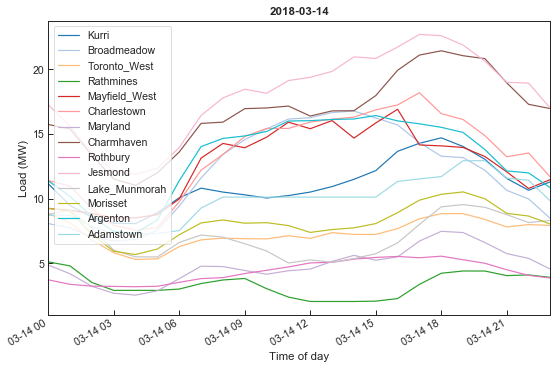

In [12]:
fig, ax = plt.subplots(figsize=(9,6))
select_date = '2018-03-14'
df.loc[select_date].plot(ax=ax, cmap=cm.get_cmap('tab20', lut=14))  # Wednesday
ax.set_title(select_date, fontweight='bold')
ax.set_xlabel('Time of day')
ax.set_ylabel('Load (MW)')
plt.show()

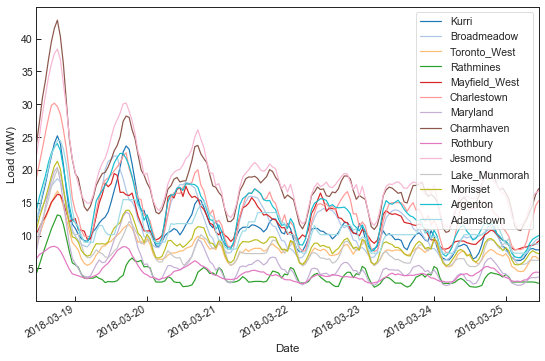

In [13]:
fig, ax = plt.subplots(figsize=(9,6))
start = pd.to_datetime('2018-03-18', utc=True).tz_convert('Australia/Sydney')
end = pd.to_datetime('2018-03-25', utc=True).tz_convert('Australia/Sydney')
df.loc[start:end].plot(ax=ax, cmap=cm.get_cmap('tab20', lut=14))
ax.set_xlabel('Date')
ax.set_ylabel('Load (MW)')
plt.show()

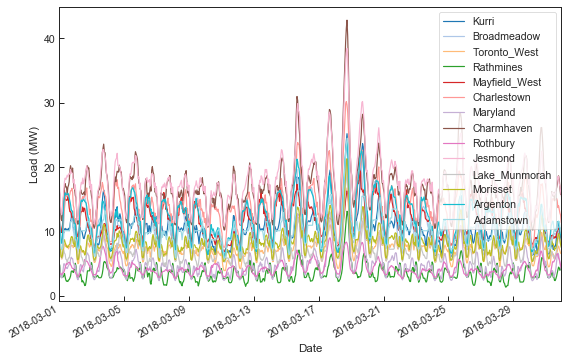

In [14]:
fig, ax = plt.subplots(figsize=(9,6))
df.loc['2018-03'].plot(ax=ax, cmap=cm.get_cmap('tab20', lut=14))
ax.set_xlabel('Date')
ax.set_ylabel('Load (MW)')
plt.show()

#### DARKSKY: Read weather data from csv files and create a single dataframe

In [15]:
def process_json_weather_files(file):
    # Read json file into pandas dataframe
    weather = pd.read_json(file)
    hourly = weather['hourly'].loc['data']
    timezone = weather['timezone'].loc['data']
    dfh = pd.DataFrame(data=hourly)
    dates = pd.to_datetime(dfh['time'], unit='s')
    dates = dates.dt.tz_localize(tz='UTC', ambiguous='NaT', nonexistent='NaT')
    dates_local = dates.dt.tz_convert(tz=timezone)
    data = pd.DataFrame(data=hourly, index=dates_local)
    data = data[['cloudCover', 'dewPoint', 'humidity', 'temperature', 'windSpeed', 'icon']]
    data.fillna(method='ffill', axis=0, inplace=True)
    return data

In [16]:
curr_path = os.getcwd()  # current working directory
wdir = 'csv_files/darksky/'
os.chdir(wdir)
files = os.listdir(os.curdir)
print('Number of weather files: {:d}'.format(len(files)))
print('Processing ...')
i = 0
for file in sorted(files):
    try:
        data = process_json_weather_files(file)
    except Exception as E:
        print(file)
        print('Exception:', E)
        os.chdir(curr_path)
    if i == 0:
        dw = data.copy()
    else:
        dw = pd.concat([dw, data], axis=0)
    i += 1
os.chdir(curr_path)
print('Done!')

Number of weather files: 365
Processing ...
Done!


In [17]:
# Resample to align weather dataframe with load time-series dataframe
dw = dw.resample('H').last()
dw.head()

,cloudCover,dewPoint,humidity,temperature,windSpeed,icon
time,,,,,,
2017-05-01 00:00:00+10:00,0.00,53.15,0.94,54.93,0.26,clear-night
2017-05-01 01:00:00+10:00,0.75,54.08,0.89,57.26,0.00,partly-cloudy-night
2017-05-01 02:00:00+10:00,0.75,51.79,0.91,54.34,0.03,partly-cloudy-night
2017-05-01 03:00:00+10:00,0.44,50.43,0.93,52.52,0.00,partly-cloudy-night
2017-05-01 04:00:00+10:00,0.00,50.73,0.90,53.71,0.00,clear-night


### Concatenate weather and power load data into a single dataframe

In [18]:
dwdf = pd.concat([dw, df], join='inner', axis=1)
#dwdf = pd.concat([dw, df_cluster], join='inner', axis=1)  # using cluster analysis
dwdf.head()

,cloudCover,dewPoint,humidity,temperature,windSpeed,icon,Kurri,Broadmeadow,Toronto_West,Rathmines,Mayfield_West,Charlestown,Maryland,Charmhaven,Rothbury,Jesmond,Lake_Munmorah,Morisset,Argenton,Adamstown
time,,,,,,,,,,,,,,,,,,,,
2017-05-01 00:00:00+10:00,0.00,53.15,0.94,54.93,0.26,clear-night,9.293187,7.355490,1.532700,5.048857,9.239147,9.248663,3.754263,17.202967,2.970837,14.750807,11.071820,8.309260,11.343457,8.010340
2017-05-01 01:00:00+10:00,0.75,54.08,0.89,57.26,0.00,partly-cloudy-night,8.921380,7.129977,1.532700,4.396555,9.246168,8.888167,3.368525,14.855965,2.884155,14.559105,9.742450,7.252880,11.364700,8.010340
2017-05-01 02:00:00+10:00,0.75,51.79,0.91,54.34,0.03,partly-cloudy-night,8.517912,6.686475,1.099477,3.346163,8.156038,7.485578,2.675347,11.802657,2.920272,13.227250,8.213660,6.088737,10.424560,7.726455
2017-05-01 03:00:00+10:00,0.44,50.43,0.93,52.52,0.00,partly-cloudy-night,8.351537,6.535708,0.978300,2.930630,8.912705,6.721820,2.284195,10.872978,2.793130,12.026525,6.252828,5.541290,9.260480,6.579920
2017-05-01 04:00:00+10:00,0.00,50.73,0.90,53.71,0.00,clear-night,8.511228,6.641385,0.978300,2.930630,8.811488,6.721820,2.287673,10.839945,2.883567,11.754460,5.640360,5.484558,8.770495,6.579920


### Features engineering (time-lags)

In [19]:
# EXAMPLE Substation
station = 'Jesmond'
#station = 'Charmhaven'  # Alternative

In [20]:
main_features = True
if main_features:
    # Use only the following main weather features
    aggdata = dwdf[['temperature', 'humidity', 'dewPoint', 'windSpeed', station]].copy()
else:
    # Use extended weather features (main features + cloudCover + ...)
    aggdata = dwdf[['temperature', 'humidity', 'dewPoint', 'windSpeed', 'cloudCover', station]].copy()
# Hour-ahead predictions (with hourly measurements)
for col in aggdata.columns:
    for i in range(1,25):
        # Shift data by lag of 1 to 24 hours
        aggdata[col+'_{:d}h'.format(i)] = aggdata[col].shift(periods=i)  # time-lag
    aggdata[col+'_diff'] = aggdata[col].diff()  # difference
    aggdata[col+'_week']  =aggdata[col].shift(periods=24*7)  # previous week
# Hour-of-day indicators with cyclical transform
dayhour_ind = aggdata.index.hour
aggdata['hr_sin'] = np.sin(dayhour_ind*(2.*np.pi/24))
aggdata['hr_cos'] = np.cos(dayhour_ind*(2.*np.pi/24))
# Day-of-week indicators with cyclical transform
weekday_ind = aggdata.index.weekday
aggdata['week_sin'] = np.sin(weekday_ind*(2.*np.pi/7))
aggdata['week_cos'] = np.cos(weekday_ind*(2.*np.pi/7))
# Weekend indicator
aggdata['weekend'] = np.asarray([0 if ind <= 4 else 1 for ind in weekday_ind])
# Month indicators with cyclical transform
month_ind = aggdata.index.month
aggdata['mnth_sin'] = np.sin((month_ind-1)*(2.*np.pi/12))
aggdata['mnth_cos'] = np.cos((month_ind-1)*(2.*np.pi/12))
# one-hot-encode weather description (icon variable)
icons = pd.get_dummies(dwdf['icon'])
aggdata = aggdata.join(icons)
# Drop rows with NaN values
aggdata.dropna(inplace=True)
aggdata.head()

,temperature,humidity,dewPoint,windSpeed,Jesmond,temperature_1h,temperature_2h,temperature_3h,temperature_4h,temperature_5h,...,mnth_sin,mnth_cos,clear-day,clear-night,cloudy,fog,partly-cloudy-day,partly-cloudy-night,rain,wind
time,,,,,,,,,,,,,,,,,,,,,
2017-05-08 00:00:00+10:00,54.03,0.79,47.76,1.44,15.021013,55.68,55.31,57.45,60.94,63.67,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 01:00:00+10:00,53.82,0.84,49.05,0.00,13.889565,54.03,55.68,55.31,57.45,60.94,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 02:00:00+10:00,51.79,0.82,46.39,0.03,12.235263,53.82,54.03,55.68,55.31,57.45,...,0.866025,-0.5,0,0,1,0,0,0,0,0
2017-05-08 03:00:00+10:00,50.15,0.87,46.32,1.49,11.728682,51.79,53.82,54.03,55.68,55.31,...,0.866025,-0.5,0,0,0,0,0,1,0,0
2017-05-08 04:00:00+10:00,51.83,0.75,44.17,1.03,11.697333,50.15,51.79,53.82,54.03,55.68,...,0.866025,-0.5,0,0,0,0,0,1,0,0


### Forecasting load profile for a single substation

In [21]:
# DATASETS DETERMINED USING THE WINDOW METHOD
features = [col for col in aggdata.columns if col != station]
window_days = 105  # width of the dataset window in days
# this window determines the size of the dataset that
# will be split into the training and validation sets
train_percent = 0.8  # percent of the dataset used for training
start_date = '2017-05-08'  # start date
# Training period
st = pd.to_datetime(start_date)
et = st + dt.timedelta(days=int(train_percent*window_days)-1)
X_train = aggdata[features].loc[st:et].values
y_train = aggdata[station].loc[st:et].values
# Validation period
sv = et + dt.timedelta(days=1)
ev = sv + dt.timedelta(days=int((1-train_percent)*window_days))
X_test = aggdata[features].loc[sv:ev].values  # validation
y_test = aggdata[station].loc[sv:ev].values   # validation
# Testing period (one week after)
sn = ev + dt.timedelta(days=1)
en = sn + dt.timedelta(days=7)
X_new = aggdata[features].loc[sn:en].values
y_true = aggdata[station].loc[sn:en].values
print(st, et, sv, ev, sn, en)

2017-05-08 00:00:00 2017-07-30 00:00:00 2017-07-31 00:00:00 2017-08-20 00:00:00 2017-08-21 00:00:00 2017-08-28 00:00:00


**Training-validation-testing procedure**:
Training data set is used for training the base models, where optimal base model's hyper-parameters are determined by the grid search with cross-validation on the training set. Validation set is used only for training the second-stage models, which stack base models in an ensemble. Two different stacking procedures are used. Again, grid search with cross-validation is used on the validation set to fine-tune the stacking ensembles. The final set of base models, along with the second-stage models (ensembles), that have been fine-tuned, are once more re-trained on the entire data set (training + validation sets). The models and ensembles are then tested using the test set (never seen before by the models).

In [22]:
print('Total number of features: {:d}'.format(len(features)))

Total number of features: 149


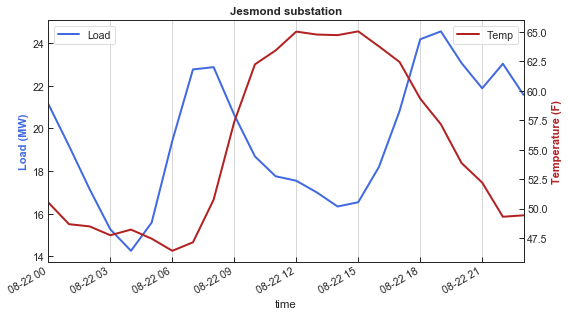

In [23]:
d = '2017-08-22'  # arbitrary day
fig, ax = plt.subplots(figsize=(8,4.5))
ax2 = ax.twinx()
ax.set_title(station+' substation', fontweight='bold')
l1 = dwdf['temperature'].loc[d].plot(ax=ax2, c='firebrick', lw=2, label='Temp')
l2 = dwdf[station].loc[d].plot(ax=ax, c='royalblue', lw=2, label='Load')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Temperature (F)', fontdict={'weight':'bold', 'color':'firebrick', 'size':11})
ax.set_ylabel('Load (MW)', fontdict={'weight':'bold', 'color':'royalblue', 'size':11})
#ax.set_xlabel('Date')
ax.grid(which='major', axis='x')
plt.tight_layout()
plt.show()

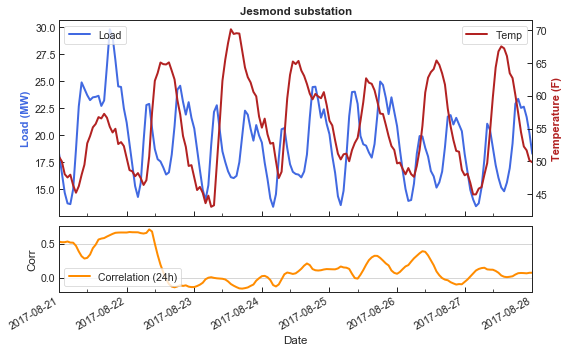

In [24]:
fig = plt.figure(figsize=(8,5))
gx = gs.GridSpec(nrows=2, ncols=1, figure=fig, height_ratios=[3,1])
ax = np.empty(shape=(2,1), dtype=np.ndarray)
ax[0,0] = fig.add_subplot(gx[0,0]); axr = ax[0,0].twinx()
ax[1,0] = fig.add_subplot(gx[1,0], sharex=ax[0,0])
ax[0,0].set_title(station+' substation', fontweight='bold')
dwdf['temperature'].loc[sn:en].plot(ax=axr, c='firebrick', lw=2, label='Temp')
dwdf[station].loc[sn:en].plot(ax=ax[0,0], c='royalblue', lw=2, label='Load')
ax[0,0].legend(loc='upper left')
axr.legend(loc='upper right')
axr.set_ylabel('Temperature (F)', fontdict={'weight':'bold', 'color':'firebrick', 'size':11})
ax[0,0].set_ylabel('Load (MW)', fontdict={'weight':'bold', 'color':'royalblue', 'size':11})
corr = dwdf[station].rolling(window=24).corr(dwdf['temperature'])
corr.loc[sn:en].plot(ax=ax[1,0], c='darkorange', lw=2, ls='-', label='Correlation (24h)')
ax[1,0].legend(loc='lower left')
ax[1,0].grid(which='major', axis='y')
ax[1,0].set_ylabel('Corr')
ax[1,0].set_xlabel('Date')
fig.tight_layout()
plt.savefig('Load_Temp.png', dpi=600)
plt.show()

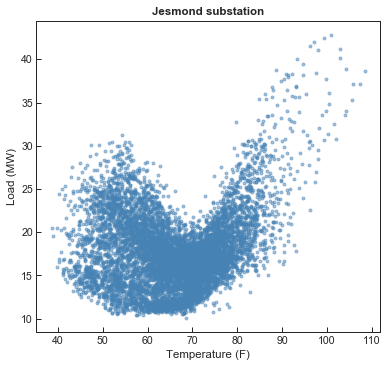

In [25]:
fig, ax = plt.subplots(figsize=(5.5,5.2))
ax.scatter(dwdf['temperature'], dwdf[station], s=10, c='steelblue', marker='o', alpha=0.5)
ax.set_title(station+' substation', fontweight='bold')
ax.set_xlabel('Temperature (F)')
ax.set_ylabel('Load (MW)')
#ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

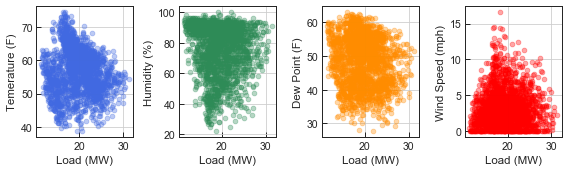

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(8,2.5))
#fig.suptitle(station+' substation', fontweight='bold')
ax[0].scatter(aggdata[station].loc[st:et].values, aggdata['temperature'].loc[st:et].values, c='royalblue', alpha=0.35)
ax[0].set_xlabel('Load (MW)')
ax[0].set_ylabel('Temerature (F)')
ax[0].grid(True)
ax[1].scatter(aggdata[station].loc[st:et].values, aggdata['humidity'].loc[st:et].values*100, c='seagreen', alpha=0.35)
ax[1].set_xlabel('Load (MW)')
ax[1].set_ylabel('Humidity (%)')
ax[1].grid(True)
ax[2].scatter(aggdata[station].loc[st:et].values, aggdata['dewPoint'].loc[st:et].values, c='darkorange', alpha=0.35)
ax[2].set_xlabel('Load (MW)')
ax[2].set_ylabel('Dew Point (F)')
ax[2].grid(True)
ax[3].scatter(aggdata[station].loc[st:et].values, aggdata['windSpeed'].loc[st:et].values, c='red', alpha=0.35)
ax[3].set_xlabel('Load (MW)')
ax[3].set_ylabel('Wind Speed (mph)')
ax[3].grid(True)
#ax[4].scatter(aggdata[station].loc[st:et].values, aggdata['cloudCover'].loc[st:et].values*100, c='magenta', alpha=0.35)
#ax[4].set_xlabel('Load (MW)')
#ax[4].set_ylabel('Cloud Cover (%)')
#ax[4].grid(True)
fig.tight_layout()
plt.savefig('Distributions.png', dpi=600)
plt.show()

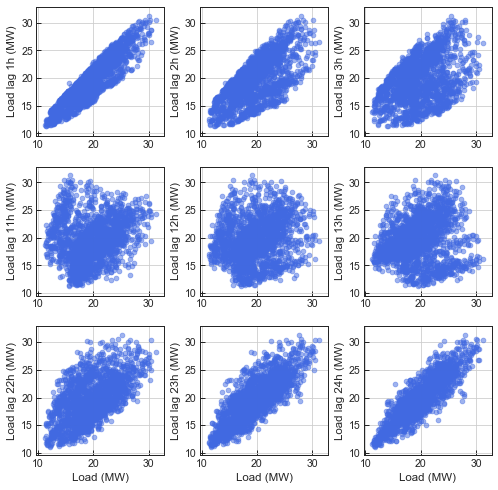

In [27]:
fig = plt.figure(figsize=(7,7))
gx = gs.GridSpec(nrows=3, ncols=3, figure=fig)
ax = np.empty(shape=(3,3), dtype=np.ndarray)
for i in range(3):
    for j in range(3):
        ax[i,j] = fig.add_subplot(gx[i,j], sharex=ax[0,0], sharey=ax[0,0], aspect='equal')
ax[0,0].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_1h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[0,0].set_ylabel('Load lag 1h (MW)')
ax[0,0].grid(True)
ax[0,1].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_2h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[0,1].set_ylabel('Load lag 2h (MW)')
ax[0,1].grid(True)
ax[0,2].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_3h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[0,2].set_ylabel('Load lag 3h (MW)')
ax[0,2].grid(True)
ax[1,0].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_11h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[1,0].set_ylabel('Load lag 11h (MW)')
ax[1,0].grid(True)
ax[1,1].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_12h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[1,1].set_ylabel('Load lag 12h (MW)')
ax[1,1].grid(True)
ax[1,2].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_13h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[1,2].set_ylabel('Load lag 13h (MW)')
ax[1,2].grid(True)
ax[2,0].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_22h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[2,0].set_xlabel('Load (MW)')
ax[2,0].set_ylabel('Load lag 22h (MW)')
ax[2,0].grid(True)
ax[2,1].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_23h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[2,1].set_xlabel('Load (MW)')
ax[2,1].set_ylabel('Load lag 23h (MW)')
ax[2,1].grid(True)
ax[2,2].scatter(aggdata[station].loc[st:et].values, aggdata[station+'_24h'].loc[st:et].values, c='royalblue', alpha=0.5)
ax[2,2].set_xlabel('Load (MW)')
ax[2,2].set_ylabel('Load lag 24h (MW)')
ax[2,2].grid(True)
fig.tight_layout()
plt.savefig('Scatter_plots.png', dpi=600)
plt.show()

### Grid search with cross-validation for optimal hyper-parameters selection

#### GradientBoostingRegressor

In [28]:
time_start = timeit.default_timer()
parameters = [{'n_estimators':[500, 750, 1000],
              'learning_rate':[0.01, 0.1, 1.],
              'max_depth':[1, 3, 5]}]
gbr = GridSearchCV(estimator=GradientBoostingRegressor(loss='ls'), 
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
gbr.fit(X_train, y_train)
print(gbr.best_params_)
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 750}
Execution time (hour:min:sec): 0:04:08.715352


#### RandomForestRegressor

In [29]:
time_start = timeit.default_timer()
parameters = {'n_estimators':[500, 1000],
              'max_depth':[1, 3, None]}
rfr = GridSearchCV(estimator=RandomForestRegressor(criterion='mse'), 
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
rfr.fit(X_train, y_train)
print(rfr.best_params_)
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'max_depth': None, 'n_estimators': 1000}
Execution time (hour:min:sec): 0:02:50.572859


### Features selection using importance analysis

In [30]:
# Feature importance analysis with gradient boosting
model = GradientBoostingRegressor(loss='ls', **gbr.best_params_)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=750,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [31]:
# Feature importance analysis with random forests
forest = RandomForestRegressor(criterion='mse', **rfr.best_params_)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [32]:
TOP = int(len(features)/2)  # max no. of top features to retain
if TOP < int(len(features)):
    # GradientBoostingRegressor
    features_importance = model.feature_importances_
    sorted_idx = np.argsort(features_importance)
    top_features_gbr = aggdata.columns.values[sorted_idx][-TOP:]
    # RandomForestRegressor
    features_importance = forest.feature_importances_
    sorted_idx = np.argsort(features_importance)
    top_features_forest = aggdata.columns.values[sorted_idx][-TOP:]
    # Intersection of features (keep only those selected by both models)
    top_features = set(top_features_gbr).intersection(set(top_features_forest))
    print('No. of features selected: {}'.format(len(top_features)))
    if len(top_features) < int(len(features)/3):
        print('WARNING: No. of selected features may be to low?!')
    top_features_index = []
    for name in top_features:
        top_features_index.append(aggdata.columns.get_loc(name))
else:
    print('ERROR: No. of features to retain must be lower than {}!'.format(len(features)))

No. of features selected: 54


In [33]:
# WARNING: Execute this cell only if select features will be used!
X_train = X_train[:, top_features_index]
X_test = X_test[:, top_features_index]
X_new = X_new[:, top_features_index]

In [34]:
# WARNING: Execute this cell only if feature selection was used!
# Re-train GradientBoostingRegressor with selected features
print('Re-training regressors with selected features ...')
time_start = timeit.default_timer()
parameters = [{'n_estimators':[500, 750, 1000],
              'learning_rate':[0.01, 0.1, 1.],
              'max_depth':[1, 3, 5]}]
gbr = GridSearchCV(estimator=GradientBoostingRegressor(loss='ls'), 
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
gbr.fit(X_train, y_train)
print(gbr.best_params_)
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

# Re-train RandomForestRegressor with selected features
time_start = timeit.default_timer()
parameters = {'n_estimators':[500, 1000],
              'max_depth':[1, 3, None]}
rfr = GridSearchCV(estimator=RandomForestRegressor(criterion='mse'), 
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
rfr.fit(X_train, y_train)
print(rfr.best_params_)
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

Re-training regressors with selected features ...


/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'learning_rate': 1.0, 'max_depth': 1, 'n_estimators': 1000}
Execution time (hour:min:sec): 0:01:36.734383


/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'max_depth': None, 'n_estimators': 500}
Execution time (hour:min:sec): 0:00:53.782000


#### BaggingRegressor with DecisionTree meta-estimator

In [35]:
time_start = timeit.default_timer()
parameters = {'n_estimators':[50, 100, 200, 500],
              'max_samples':[0.5, 1.0],
              'max_features':[0.5, 1.0]}
bag = GridSearchCV(estimator=BaggingRegressor(base_estimator=DecisionTreeRegressor(n_estimators=100), # default
                                              bootstrap_features=True),
                   param_grid=parameters, cv=TimeSeriesSplit(n_splits=3),
                   scoring='neg_mean_squared_error', 
                   refit=True, n_jobs=-1, iid=False)
bag.fit(X_train, y_train)
print(bag.best_params_)
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


{'max_features': 1.0, 'max_samples': 1.0, 'n_estimators': 50}
Execution time (hour:min:sec): 0:00:30.777361


#### Bayesian optimization for SVR hyper-parameter selection

In [36]:
def svr_cv(C, epsilon, kernel, data, targets):
    """SVR cross validation.
    This function will instantiate a SVR regressor with parameters C and
    epsilon. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    The goal is to find combinations of C and epsilon that maximizes the 
    'neg_mean_squared_error' metric.
    """
    estimator = SVR(C=C, epsilon=epsilon, gamma='scale', kernel=kernel)
    cval = cross_val_score(estimator, data, targets, scoring='neg_mean_squared_error', 
                           cv=TimeSeriesSplit(n_splits=3), n_jobs=-1)
    return cval.mean()

In [37]:
def optimize_svr(data, targets, kernel, N):
    """Apply Bayesian Optimization to SVR parameters."""
    def svr_crossval(expC, expEpsilon):
        """Wrapper of SVR cross validation.
        Notice the transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10**expC
        epsilon = 10**expEpsilon
        return svr_cv(C=C, epsilon=epsilon, kernel=kernel, data=data, targets=targets)

    optimizer = BayesianOptimization(f=svr_crossval,
                                     pbounds={'expC':(-2,4), 'expEpsilon':(-5,0)},
                                     verbose=1)
    # NOTE: "pbounds" dict defines the ranges for the SVR hyper-parameters in log-space.
    # This is where the user needs to set the appropriate boundaries of the search-space.
    optimizer.maximize(init_points=5, n_iter=N)
    return optimizer.max

In [38]:
kernel = 'rbf'
print('    --- Optimizing SVR with RBF kernel ---')
time_start = timeit.default_timer()
best_parameters = optimize_svr(X_train, y_train, kernel=kernel, N=25)
print('Final result:', best_parameters['params'])
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

    --- Optimizing SVR with RBF kernel ---
|   iter    |  target   |   expC    | expEps... |
-------------------------------------------------
|  7        | -0.02524  |  2.457    | -2.161    |
|  10       | -0.0176   |  3.229    | -2.238    |
|  11       | -0.01394  |  2.955    | -3.128    |
|  12       | -0.01287  |  3.884    | -3.185    |
|  13       | -0.01237  |  3.399    | -4.195    |
|  19       | -0.01229  |  4.0      | -5.0      |
Final result: {'expC': 4.0, 'expEpsilon': -5.0}
Execution time (hour:min:sec): 0:10:14.521169


NOTE: Bayesian Optimization is searching for the optimal model's hyper-parameters---with a scoring method being "negative mean squared error"---within the user-provided range of values and for the user-specified number of iteration steps. Other aspects of the algorithm can be controlled as well (see the package documentation for more information). The algorithm is exploring the space of possible hyper-parameter values using the so-called exploration--exploitation paradigm, which can be controlled by providing the appropriate algorithm's control settings.

In [39]:
# Instantiate optimal estimator and fit to data
time_start = timeit.default_timer()  # start timer
C = 10**best_parameters['params']['expC']
epsilon = 10**best_parameters['params']['expEpsilon']
svrb = SVR(C=C, epsilon=epsilon, gamma='scale', kernel=kernel)
svrb.fit(X_train, y_train)
# End timer and calculate execution time
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

Execution time (hour:min:sec): 0:04:36.899239


### Ensemble of individual predictors by stacking

In [40]:
# Define MAPE error metric
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)/y_true))*100.

In [41]:
# Predictions on the validation dataset
# These are used for stacking the base models
predictors = [gbr, rfr, svrb, bag]
X_pred = []
for predictor in predictors:
    X_pred.append(predictor.predict(X_test))
X_pred = np.asarray(X_pred).T

In [42]:
# Base models prediction errors on the validation set
names = ['GradientBoostingRegressor', 
         'RandomForestRegressor', 
         'SVR with BayesOptim',
         'Bagging with DecisionTree']
print('VALIDATION SET ERRORS:')
for name, y in zip(names, X_pred.T):
    mape = mean_absolute_percentage_error(y_test, y)
    print('{:>25}: MAPE = {:.2f} (%)'.format(name, mape))

VALIDATION SET ERRORS:
GradientBoostingRegressor: MAPE = 0.84 (%)
    RandomForestRegressor: MAPE = 1.33 (%)
      SVR with BayesOptim: MAPE = 0.13 (%)
Bagging with DecisionTree: MAPE = 2.27 (%)


#### Optimize weights with ElasticNet regression

ElasticNet linear regression includes L1 and L2 penalisation. It is here used without the intercept term in order to learn (using cross-validation on the validation data set) the weights distribution between the base models in the stacked ensemble.

In [43]:
# ElasticNet linear regression without intercept (stacker)
# Grid search with cross-validation on the validation dataset  
# for hyper-parameters optimisation (i.e. optimal L1 ratio)
elnet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], fit_intercept=False,
                     cv=TimeSeriesSplit(n_splits=3), max_iter=10000, n_jobs=-1)
elnet.fit(X_pred, y_test)
print('Optimal weights: {}; Sum of weights: {}'.format(elnet.coef_.round(3), elnet.coef_.sum().round(3)))

Optimal weights: [0.331 0.133 0.534 0.   ]; Sum of weights: 0.999


It can be seen that the stacking ensemble is excluding the Bagging regressor from the final ensemble (weight of zero), due to its poor performance on the validation data set. This is incidental and may change with different data and/or runs due to the stochastic nature of the bagging process.

### Predict load on the test dataset

In [44]:
# Using ALL available data from both train and validation datasets
X_all = aggdata[features].loc[st:ev].values  # train + validation
y_all = aggdata[station].loc[st:ev].values   # train + validation

In [45]:
# WARNING: Execute this cell only if select features were used!
X_all = X_all[:, top_features_index]

In [46]:
# NOTICE: Executing this cell can take some time!
# Re-train all regressors using train and validation datasets
time_start = timeit.default_timer()
for name, predictor in zip(names, predictors):
    print(name, '...')
    predictor.fit(X_all, y_all)
# Calculate execution (CPU) time
time_end = timeit.default_timer()
time_elapsed = time_end - time_start
print('Execution time (hour:min:sec): {}'.format(str(dt.timedelta(seconds=time_elapsed))))

GradientBoostingRegressor ...


/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomForestRegressor ...


/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


SVR with BayesOptim ...
Bagging with DecisionTree ...


/home/ps/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:825: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Execution time (hour:min:sec): 0:25:55.034511


In [47]:
# Predictions on the test dataset (previously unseen data)
# with the base regressors
X_pred_new = []
for predictor in predictors:
    X_pred_new.append(predictor.predict(X_new))
X_pred_new = np.asarray(X_pred_new).T
# Ensemble with ElasticNet
# Stacking predictions using weights
y_pred = elnet.predict(X_pred_new)

In [48]:
# Prediction errors on the test data set
predictions = [p for p in X_pred_new.T]
predictions.extend((y_pred,))
names.extend(('Ensemble from ElasticNet',))
print('TEST SET ERRORS:')
for name, y in zip(names, predictions):
    rmse = np.sqrt(mean_squared_error(y_true, y))
    mape = mean_absolute_percentage_error(y_true, y)
    mae = mean_absolute_error(y_true, y)
    print('{:>25}: MAPE = {:.2f} (%); RMSE = {:.3f} (MW); MAE = {:.3f} (MW)'.format(name, mape, rmse, mae))

TEST SET ERRORS:
GradientBoostingRegressor: MAPE = 0.63 (%); RMSE = 0.153 (MW); MAE = 0.121 (MW)
    RandomForestRegressor: MAPE = 1.03 (%); RMSE = 0.283 (MW); MAE = 0.194 (MW)
      SVR with BayesOptim: MAPE = 0.09 (%); RMSE = 0.024 (MW); MAE = 0.017 (MW)
Bagging with DecisionTree: MAPE = 2.63 (%); RMSE = 0.701 (MW); MAE = 0.513 (MW)
 Ensemble from ElasticNet: MAPE = 0.31 (%); RMSE = 0.077 (MW); MAE = 0.060 (MW)


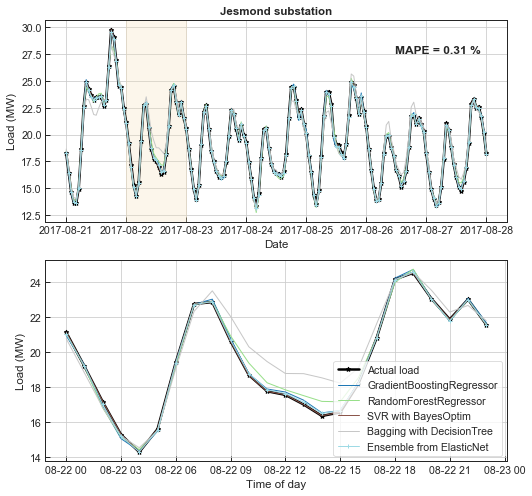

In [49]:
idx = dwdf.loc[sn:en].index  # index values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7.5,7))
ax1.set_title(station+' substation', fontweight='bold')
ax1.plot(idx, y_true, c='black', lw=2.5, marker='*', label='Actual load')
ax1.text(0.85, 0.85, 'MAPE = {:.2f} %'.format(mape), 
         horizontalalignment='center', verticalalignment='center', 
         fontsize=12, fontweight='bold',
         transform=ax1.transAxes)  # relative coordinates
cmap = cm.get_cmap('tab20', lut=len(names))
colors = [cmap(i) for i in range(len(names))]
for name, y, c in zip(names, predictions, colors):
    if 'Ensemble' in name:
        ax1.plot(idx, y, color=c, marker='+', lw=1, label=name)
    else:
        ax1.plot(idx, y, color=c, lw=1, label=name)
ax1.set_ylabel('Load (MW)')
ax1.set_xlabel('Date')
ax1.grid(True)
s = 24  # starting index of inset
e = 48  # ending index of inset
ax1.axvspan(idx[s], idx[e], color='wheat', alpha=0.25, lw=1)
ax2.plot(idx[s:e], y_true[s:e], c='black', lw=2.5, marker='*', label='Actual load')
for name, y, c in zip(names, predictions, colors):
    if 'Ensemble' in name:
        ax2.plot(idx[s:e], y[s:e], color=c, marker='+', lw=1, label=name)
    else:
        ax2.plot(idx[s:e], y[s:e], color=c, lw=1, label=name)
ax2.legend(loc='best')
ax2.set_ylabel('Load (MW)')
ax2.set_xlabel('Time of day')
ax2.grid(True)
fig.tight_layout()
plt.savefig(station+'-models.png', dpi=600)
plt.show()

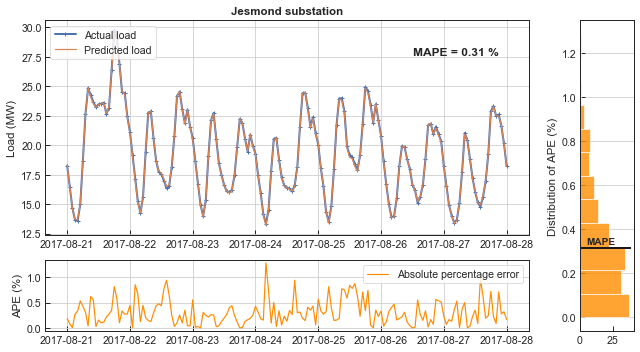

In [50]:
fig = plt.figure(figsize=(9,5))
gx = gs.GridSpec(nrows=2, ncols=2, figure=fig, height_ratios=[3,1], width_ratios=[9,1])
ax = np.empty(shape=(2,1), dtype=np.ndarray)
ax[0,0] = fig.add_subplot(gx[0,0])
ax[1,0] = fig.add_subplot(gx[1,0], sharex=ax[0,0])
axr = fig.add_subplot(gx[:,1])
ax[0,0].set_title(station+' substation', fontweight='bold')
ax[0,0].plot(dwdf.loc[sn:en].index, y_true, lw=2, marker='+', label='Actual load')
ax[0,0].plot(dwdf.loc[sn:en].index, y_pred, label='Predicted load')
ax[0,0].text(0.85, 0.85, 'MAPE = {:.2f} %'.format(mape), 
             horizontalalignment='center', verticalalignment='center', 
             fontsize=12, fontweight='bold',
             transform=ax[0,0].transAxes)  # relative coordinates
ax[0,0].legend(loc='upper left')
ax[0,0].set_ylabel('Load (MW)')
ax[0,0].grid(True)
# Absolute percentage error
abs_perc_error = np.abs((y_true - y_pred) / y_true)*100.
ax[1,0].plot(dwdf.loc[sn:en].index, abs_perc_error, color='darkorange', 
             label='Absolute percentage error')
ax[1,0].legend(loc='upper right')
ax[1,0].set_ylabel('APE (%)')
ax[1,0].grid(True)
# Histogram of error distribution
axr.hist(abs_perc_error, bins='fd', orientation='horizontal', color='darkorange', alpha=0.8)
xlims = axr.get_xlim()
axr.hlines(mape, 0, xlims[1], colors='k', lw=2)
axr.text(5, mape+0.02, 'MAPE', fontweight='bold')
#axr.spines['right'].set_visible(False)
axr.grid(axis='y')
axr.set_ylabel('Distribution of APE (%)')
fig.tight_layout()
plt.savefig(station+'.png', dpi=600)
plt.show()